In [1]:
%time 1+1

Wall time: 0 ns


2

In [1]:
from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, BatchNormalization
from keras.models import Model
from string import punctuation
from os import listdir
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.optimizers import SGD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
import numpy as np

C:\Anaconda2\envs\python3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from sklearn.datasets import load_iris
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os
import sys
import time
import lightgbm as lgb

from bayes_opt import BayesianOptimization
from scipy.stats import pearsonr

import warnings
import lightgbm as lgb

warnings.filterwarnings("ignore")

In [3]:
def save_dataframe(path, dataframe):
    np.save(path + ".data", dataframe.values)
    np.save(path + ".header", dataframe.columns)
    
def load_dataframe(path):
    data = np.load(path + ".data.npy")
    header = np.load(path + ".header.npy")
    return pd.DataFrame(data=data, columns=header)

def save_dataframe32(path, dataframe, keep=[]):
    col64 = [col_ for col_ in dataframe.columns if col_ in keep]
    col32 = [col_ for col_ in dataframe.columns if col_ not in keep]
    dataframe64 = dataframe[col64]
    dataframe32 = dataframe[col32]
    np.save(path + ".data64", dataframe64.values)
    np.save(path + ".header64", col64)
    np.save(path + ".data32", dataframe32.values.astype(np.float32))
    np.save(path + ".header32", col32)

def load_dataframe32(path):
    path_data32 = path + ".data32.npy"
    path_header32 = path + ".header32.npy"
    path_data64 = path + ".data64.npy"
    path_header64 = path + ".header64.npy"
    result = pd.DataFrame()
    if os.path.exists(path_data32):
        data32 = np.load(path_data32)
        header32 = np.load(path_header32)
        df32 = pd.DataFrame(data=data32, columns=header32)
        result = pd.concat([result, df32], axis=1)
    if os.path.exists(path_data64):
        data64 = np.load(path_data64)
        header64 = np.load(path_header64)
        df64 = pd.DataFrame(data=data64, columns=header64)
        result = pd.concat([result, df64], axis=1)
    return result

## load data

In [6]:
data = load_dataframe32("./bindata/data_013")
data["SK_ID_CURR"] = data.SK_ID_CURR.astype("int")

test = load_dataframe32("./bindata/test_013")
test["SK_ID_CURR"] = test.SK_ID_CURR.astype("int")

y = load_dataframe32("./bindata/y_013")
y["SK_ID_CURR"] = y.SK_ID_CURR.astype("int")

features_selected = list(np.load("./models/features-selected-016.npy"))

features_list = []
features_list.append([col_ for col_ in features_selected if col_ in data.columns])

In [8]:
for source_name in (
    "buro_wide_013",
    "buro_full_wide_013",
    "pos_bal_wide_013",
    "cc_bal_wide_013",
    "buro_bal_timestep1_013",
    "buro_bal_timestep2_013",
    "pos_bal_timestep1_013",
    "pos_bal_timestep2_013",
    "cc_bal_timestep1_013",
    "cc_bal_timestep2_013"
):
    target_name = "./bindata/" + source_name + "_nmf5"
    nmf_data = load_dataframe32(target_name)
    nmf_data["SK_ID_CURR"] = nmf_data.SK_ID_CURR.astype("int")
    nmf_data.columns = ["{}_{}".format(source_name, col_) if col_ != "SK_ID_CURR" else col_ for col_ in nmf_data.columns]
    data = data.merge(right=nmf_data, how="left", on="SK_ID_CURR")
    test = test.merge(right=nmf_data, how="left", on="SK_ID_CURR")
    features_list.append([col_ for col_ in nmf_data.columns if col_ in features_selected])
    del nmf_data
    gc.collect()
    
buro_wide = load_dataframe32("./bindata/buro_wide_013")
buro_full_wide = load_dataframe32("./bindata/buro_full_wide_013")
pos_bal_wide = load_dataframe32("./bindata/pos_bal_wide_013")
cc_bal_wide = load_dataframe32("./bindata/cc_bal_wide_013")

buro_wide["SK_ID_CURR"] = buro_wide.SK_ID_CURR.astype("int")
buro_full_wide["SK_ID_CURR"] = buro_full_wide.SK_ID_CURR.astype("int")
pos_bal_wide["SK_ID_CURR"] = pos_bal_wide.SK_ID_CURR.astype("int")
cc_bal_wide["SK_ID_CURR"] = cc_bal_wide.SK_ID_CURR.astype("int")

for wi, data_ in enumerate((buro_wide, buro_full_wide, pos_bal_wide, cc_bal_wide)):
    # data_.columns = ["w{}_{}".format(wi, col_) for col_ in data_.columns]
    data = data.merge(right=data_, how="left", on="SK_ID_CURR")
    test = test.merge(right=data_, how="left", on="SK_ID_CURR")
    features_list.append([col_ for col_ in data_.columns if col_ in features_selected])
    del data_
    gc.collect()
    
for name in (
    "./bindata/bureau_and_balance_015",
    "./bindata/previous_applications_015",
    "./bindata/pos_cash_015",
    "./bindata/installments_payments_015",
    "./bindata/credit_card_balance_015",
):
    data_ = load_dataframe32(name)
    data_["SK_ID_CURR"] = data_.SK_ID_CURR.astype("int")
    data = data.merge(right=data_, how="left", on="SK_ID_CURR")
    test = test.merge(right=data_, how="left", on="SK_ID_CURR")
    features_list.append([col_ for col_ in data_.columns if col_ in features_selected])
    del data_
    gc.collect()

## train & validate

In [13]:
for ftrs_ in features_list:
    input_dim = len(ftrs_)
    print(input_dim, int(np.log(input_dim) * np.sqrt(input_dim)))

289 96
49 27
50 27
50 27
50 27
49 27
49 27
50 27
50 27
46 25
50 27
12 8
85 40
34 20
7 5
74 37
175 68
7 5
24 15
50 27


In [15]:
data_train = data[data.SK_ID_CURR < 130000]
data_val = data[(data.SK_ID_CURR >= 130000) & (data.SK_ID_CURR < 150000)]

ydata_train = y[y.SK_ID_CURR < 130000]
ydata_val = y[(y.SK_ID_CURR >= 130000) & (y.SK_ID_CURR < 150000)]

## keras -val

In [16]:
scaler_stack = {"part_{}".format(i): StandardScaler() for i in range(len(features_list))}
scaler_stack

{'part_0': StandardScaler(copy=True, with_mean=True, with_std=True),
 'part_1': StandardScaler(copy=True, with_mean=True, with_std=True),
 'part_10': StandardScaler(copy=True, with_mean=True, with_std=True),
 'part_11': StandardScaler(copy=True, with_mean=True, with_std=True),
 'part_12': StandardScaler(copy=True, with_mean=True, with_std=True),
 'part_13': StandardScaler(copy=True, with_mean=True, with_std=True),
 'part_14': StandardScaler(copy=True, with_mean=True, with_std=True),
 'part_15': StandardScaler(copy=True, with_mean=True, with_std=True),
 'part_16': StandardScaler(copy=True, with_mean=True, with_std=True),
 'part_17': StandardScaler(copy=True, with_mean=True, with_std=True),
 'part_18': StandardScaler(copy=True, with_mean=True, with_std=True),
 'part_19': StandardScaler(copy=True, with_mean=True, with_std=True),
 'part_2': StandardScaler(copy=True, with_mean=True, with_std=True),
 'part_3': StandardScaler(copy=True, with_mean=True, with_std=True),
 'part_4': StandardScale

In [22]:
def replace_nan(X):
    X = X.copy()
    X[np.isnan(X)] = 0
    X[X == np.Inf] = X[X != np.Inf].max()
    X[X == -np.Inf] = X[X != -np.Inf].min()
    print(X.shape, X.max(), X.min())
    return X

In [31]:
y_train = ydata_train.TARGET.values
y_val = ydata_val.TARGET.values

In [24]:
scaler_stack = {"part_{}".format(i): StandardScaler() for i in range(len(features_list))}

X_train_mult = {
    "part_{}".format(i): scaler_stack["part_{}".format(i)].fit_transform(replace_nan(data_train[ftrs_].values))
    for i, ftrs_ in enumerate(features_list)
}

X_val_mult = {
    "part_{}".format(i): scaler_stack["part_{}".format(i)].transform(replace_nan(data_val[ftrs_].values))
    for i, ftrs_ in enumerate(features_list)
}

(25803, 289) 117000000.0 -83570.53
(25803, 49) 5.219319 0.0
(25803, 50) 5.7959313 0.0
(25803, 50) 5.78628 0.0
(25803, 50) 2.557896 0.0
(25803, 49) 4.7320404 0.0
(25803, 49) 3.7580695 0.0
(25803, 50) 2.8214033 0.0
(25803, 50) 59.395172 0.0
(25803, 46) 19.552704 0.0
(25803, 50) 5.608598 0.0
(25803, 12) 116.0 0.0
(25803, 85) 92070000.0 -551247.2
(25803, 34) 245.0 -191.0
(25803, 7) 121.0 -191.0
(25803, 74) 113612690.0 -1509471.5
(25803, 175) 4185000.0 -2922.0
(25803, 7) 3731.0 -96.0
(25803, 24) 275869700000.0 -3913034.0
(25803, 50) 364500000000.0 -72512.01
(17390, 289) 142290000.0 -1083614.6
(17390, 49) 5.2193184 0.0
(17390, 50) 6.4157505 0.0
(17390, 50) 5.7063584 0.0
(17390, 50) 2.391242 0.0
(17390, 49) 4.295033 0.0
(17390, 49) 3.8651142 0.0
(17390, 50) 2.9838037 0.0
(17390, 50) 63.318184 0.0
(17390, 46) 14.622345 0.0
(17390, 50) 5.5326524 0.0
(17390, 12) 45.0 0.0
(17390, 85) 142290000.0 -2167229.2
(17390, 34) 198.0 -191.0
(17390, 7) 96.0 -191.0
(17390, 74) 214663680.0 -12498547.0
(17390,

In [26]:
def less_ftr(input_dim):
    return int(np.log(input_dim) * np.sqrt(input_dim))

In [34]:
input_lyr = [
    Input(shape=[len(ftrs_)], name="part_{}".format(i))
    for i, ftrs_ in enumerate(features_list)
]

dense0_lyr = [
    Dense(less_ftr(len(ftrs_)), activation="relu")(input_lyr[i])
    for i, ftrs_ in enumerate(features_list)
]

main0_lyr = concatenate(dense0_lyr)
drop0_lyr = Dropout(.75)(main0_lyr)
main1_lyr = Dense(128, activation="relu")(drop0_lyr)
output = Dense(1, activation="sigmoid")(main1_lyr)

model = Model(input_lyr, output)

In [35]:
model.compile(loss="binary_crossentropy", optimizer="adam")
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
part_0 (InputLayer)             (None, 289)          0                                            
__________________________________________________________________________________________________
part_1 (InputLayer)             (None, 49)           0                                            
__________________________________________________________________________________________________
part_2 (InputLayer)             (None, 50)           0                                            
__________________________________________________________________________________________________
part_3 (InputLayer)             (None, 50)           0                                            
__________________________________________________________________________________________________
part_4 (In

In [36]:
model.fit(X_train_mult, y_train, nb_epoch=10)

Epoch 1/10
25803/25803 [==============================] - 17s 660us/step - loss: 0.3025
Epoch 2/10
25803/25803 [==============================] - 16s 602us/step - loss: 0.2658
Epoch 3/10
25803/25803 [==============================] - 16s 602us/step - loss: 0.2553
Epoch 4/10
25803/25803 [==============================] - 16s 603us/step - loss: 0.2514
Epoch 5/10
25803/25803 [==============================] - 16s 603us/step - loss: 0.2465
Epoch 6/10
25803/25803 [==============================] - 16s 603us/step - loss: 0.2475
Epoch 7/10
25803/25803 [==============================] - 16s 604us/step - loss: 0.2431
Epoch 8/10
25803/25803 [==============================] - 16s 604us/step - loss: 0.2421
Epoch 9/10
25803/25803 [==============================] - 16s 606us/step - loss: 0.2386
Epoch 10/10
25803/25803 [==============================] - 16s 606us/step - loss: 0.2389


In [37]:
pred_train = model.predict(X_train_mult)
pred_val = model.predict(X_val_mult)
roc_train = roc_auc_score(y_train, pred_train)
roc_val = roc_auc_score(y_val, pred_val)
print("train-score: {}, val-score: {}".format(roc_train, roc_val))

train-score: 0.8262010896311027, val-score: 0.7448871119777435


In [79]:
input_lyr = [
    Input(shape=[len(ftrs_)], name="part_{}".format(i))
    for i, ftrs_ in enumerate(features_list)
]

dense0_lyr = [
    Dense(less_ftr(len(ftrs_)), activation="relu")(input_lyr[i])
    for i, ftrs_ in enumerate(features_list)
]

main0_lyr = concatenate(dense0_lyr)
drop0_lyr = Dropout(.8)(main0_lyr)
main1_lyr = Dense(128, activation="relu")(drop0_lyr)
drop1_lyr = Dropout(.8)(main1_lyr)
main2_lyr = Dense(64, activation="relu")(drop1_lyr)
output = Dense(1, activation="sigmoid")(main2_lyr)

model = Model(input_lyr, output)
model.compile(loss="binary_crossentropy", optimizer="adam")

In [80]:
model.fit(X_train_mult, y_train, nb_epoch=10)

Epoch 1/10
25803/25803 [==============================] - 19s 726us/step - loss: 0.3673
Epoch 2/10
25803/25803 [==============================] - 17s 641us/step - loss: 0.3020
Epoch 3/10
25803/25803 [==============================] - 17s 642us/step - loss: 0.2812
Epoch 4/10
25803/25803 [==============================] - 17s 643us/step - loss: 0.2736
Epoch 5/10
25803/25803 [==============================] - 17s 643us/step - loss: 0.2687
Epoch 6/10
25803/25803 [==============================] - 17s 646us/step - loss: 0.2621
Epoch 7/10
25803/25803 [==============================] - 17s 653us/step - loss: 0.2588
Epoch 8/10
25803/25803 [==============================] - 17s 671us/step - loss: 0.2567
Epoch 9/10
25803/25803 [==============================] - 17s 654us/step - loss: 0.2550
Epoch 10/10
25803/25803 [==============================] - 17s 662us/step - loss: 0.2526


In [81]:
pred_train = model.predict(X_train_mult)
pred_val = model.predict(X_val_mult)
roc_train = roc_auc_score(y_train, pred_train)
roc_val = roc_auc_score(y_val, pred_val)
print("train-score: {}, val-score: {}".format(roc_train, roc_val))

train-score: 0.7946341734253551, val-score: 0.7379510660942417


In [82]:
model.fit(X_train_mult, y_train, nb_epoch=2)
pred_train = model.predict(X_train_mult)
pred_val = model.predict(X_val_mult)
roc_train = roc_auc_score(y_train, pred_train)
roc_val = roc_auc_score(y_val, pred_val)
print("train-score: {}, val-score: {}".format(roc_train, roc_val))

Epoch 1/2
25803/25803 [==============================] - 17s 647us/step - loss: 0.2533
Epoch 2/2
25803/25803 [==============================] - 17s 643us/step - loss: 0.2521
train-score: 0.8012751506678544, val-score: 0.7404976437993883


In [83]:
for i in range(3):
    model.fit(X_train_mult, y_train, nb_epoch=2)
    pred_train = model.predict(X_train_mult)
    pred_val = model.predict(X_val_mult)
    roc_train = roc_auc_score(y_train, pred_train)
    roc_val = roc_auc_score(y_val, pred_val)
    print("train-score: {}, val-score: {}".format(roc_train, roc_val))

Epoch 1/2
25803/25803 [==============================] - 17s 645us/step - loss: 0.2488
Epoch 2/2
25803/25803 [==============================] - 17s 654us/step - loss: 0.2484
train-score: 0.8057888090539804, val-score: 0.7413818090404121
Epoch 1/2
25803/25803 [==============================] - 17s 650us/step - loss: 0.2466
Epoch 2/2
25803/25803 [==============================] - 17s 649us/step - loss: 0.2458
train-score: 0.8101397708473664, val-score: 0.7413191148391691
Epoch 1/2
25803/25803 [==============================] - 17s 643us/step - loss: 0.2469
Epoch 2/2
25803/25803 [==============================] - 17s 643us/step - loss: 0.2480
train-score: 0.8122814001250718, val-score: 0.7417005245946575


In [84]:
for i in range(5):
    model.fit(X_train_mult, y_train, nb_epoch=2)
    pred_train = model.predict(X_train_mult)
    pred_val = model.predict(X_val_mult)
    roc_train = roc_auc_score(y_train, pred_train)
    roc_val = roc_auc_score(y_val, pred_val)
    print("train-score: {}, val-score: {}".format(roc_train, roc_val))

Epoch 1/2
25803/25803 [==============================] - 17s 645us/step - loss: 0.2450
Epoch 2/2
25803/25803 [==============================] - 17s 644us/step - loss: 0.2451
train-score: 0.8164771480996763, val-score: 0.7399991495091278
Epoch 1/2
25803/25803 [==============================] - 17s 646us/step - loss: 0.2447
Epoch 2/2
25803/25803 [==============================] - 17s 644us/step - loss: 0.2439
train-score: 0.8194792144917604, val-score: 0.7379990755610006
Epoch 1/2
25803/25803 [==============================] - 17s 644us/step - loss: 0.2440
Epoch 2/2
25803/25803 [==============================] - 17s 642us/step - loss: 0.2420
train-score: 0.8237329923508648, val-score: 0.7383750222456246
Epoch 1/2
25803/25803 [==============================] - 17s 640us/step - loss: 0.2420
Epoch 2/2
25803/25803 [==============================] - 17s 642us/step - loss: 0.2407
train-score: 0.8254902261050664, val-score: 0.739128991581801
Epoch 1/2
25803/25803 [==============================

## keras -tune

In [115]:
input_lyr = [
    Input(shape=[len(ftrs_)], name="part_{}".format(i))
    for i, ftrs_ in enumerate(features_list)
]

dense0_lyr = [
    Dense(less_ftr(len(ftrs_)), activation="relu")(input_lyr[i])
    for i, ftrs_ in enumerate(features_list)
]

main0_lyr = concatenate(dense0_lyr)
drop0_lyr = Dropout(.7)(main0_lyr)
main1_lyr = Dense(88, activation="relu")(drop0_lyr)
output = Dense(1, activation="sigmoid")(main1_lyr)

model = Model(input_lyr, output)
model.compile(loss="binary_crossentropy", optimizer="adam")

model.fit(X_train_mult, y_train, nb_epoch=5)
pred_train = model.predict(X_train_mult)
pred_val = model.predict(X_val_mult)
roc_train = roc_auc_score(y_train, pred_train)
roc_val = roc_auc_score(y_val, pred_val)
print("train-score: {}, val-score: {}".format(roc_train, roc_val))

model.fit(X_train_mult, y_train, nb_epoch=2)
pred_train = model.predict(X_train_mult)
pred_val = model.predict(X_val_mult)
roc_train = roc_auc_score(y_train, pred_train)
roc_val = roc_auc_score(y_val, pred_val)
print("train-score: {}, val-score: {}".format(roc_train, roc_val))

Epoch 1/5
25803/25803 [==============================] - 19s 740us/step - loss: 0.3011
Epoch 2/5
25803/25803 [==============================] - 16s 624us/step - loss: 0.2628
Epoch 3/5
25803/25803 [==============================] - 16s 633us/step - loss: 0.2535
Epoch 4/5
25803/25803 [==============================] - 16s 634us/step - loss: 0.2488
Epoch 5/5
25803/25803 [==============================] - 16s 633us/step - loss: 0.2452
train-score: 0.8145004674123454, val-score: 0.7462212812920329
Epoch 1/2
25803/25803 [==============================] - 16s 636us/step - loss: 0.2419
Epoch 2/2
25803/25803 [==============================] - 16s 631us/step - loss: 0.2393
train-score: 0.8260679863345507, val-score: 0.7483187508675355


In [113]:
input_lyr = [
    Input(shape=[len(ftrs_)], name="part_{}".format(i))
    for i, ftrs_ in enumerate(features_list)
]

dense0_lyr = [
    Dense(less_ftr(len(ftrs_)), activation="relu")(input_lyr[i])
    for i, ftrs_ in enumerate(features_list)
]

main0_lyr = concatenate(dense0_lyr)
drop0_lyr = Dropout(.7)(main0_lyr)
main1_lyr = Dense(64, activation="relu")(drop0_lyr)
output = Dense(1, activation="sigmoid")(main1_lyr)

model = Model(input_lyr, output)
model.compile(loss="binary_crossentropy", optimizer="adam")

model.fit(X_train_mult, y_train, nb_epoch=5)
pred_train = model.predict(X_train_mult)
pred_val = model.predict(X_val_mult)
roc_train = roc_auc_score(y_train, pred_train)
roc_val = roc_auc_score(y_val, pred_val)
print("train-score: {}, val-score: {}".format(roc_train, roc_val))

Epoch 1/5
25803/25803 [==============================] - 19s 731us/step - loss: 0.2960
Epoch 2/5
25803/25803 [==============================] - 17s 652us/step - loss: 0.2614
Epoch 3/5
25803/25803 [==============================] - 17s 649us/step - loss: 0.2541
Epoch 4/5
25803/25803 [==============================] - 17s 648us/step - loss: 0.2473
Epoch 5/5
25803/25803 [==============================] - 17s 647us/step - loss: 0.2444
train-score: 0.8145585484786098, val-score: 0.7439844378526305


In [114]:
model.fit(X_train_mult, y_train, nb_epoch=2)
pred_train = model.predict(X_train_mult)
pred_val = model.predict(X_val_mult)
roc_train = roc_auc_score(y_train, pred_train)
roc_val = roc_auc_score(y_val, pred_val)
print("train-score: {}, val-score: {}".format(roc_train, roc_val))

Epoch 1/2
25803/25803 [==============================] - 17s 648us/step - loss: 0.2423
Epoch 2/2
25803/25803 [==============================] - 17s 650us/step - loss: 0.2397
train-score: 0.827288374561746, val-score: 0.7433527757469722


In [110]:
input_lyr = [
    Input(shape=[len(ftrs_)], name="part_{}".format(i))
    for i, ftrs_ in enumerate(features_list)
]

dense0_lyr = [
    Dense(less_ftr(len(ftrs_)), activation="relu")(input_lyr[i])
    for i, ftrs_ in enumerate(features_list)
]

main0_lyr = concatenate(dense0_lyr)
drop0_lyr = Dropout(.7)(main0_lyr)
main1_lyr = Dense(100, activation="relu")(drop0_lyr)
output = Dense(1, activation="sigmoid")(main1_lyr)

model = Model(input_lyr, output)
model.compile(loss="binary_crossentropy", optimizer="adam")

model.fit(X_train_mult, y_train, nb_epoch=10)
pred_train = model.predict(X_train_mult)
pred_val = model.predict(X_val_mult)
roc_train = roc_auc_score(y_train, pred_train)
roc_val = roc_auc_score(y_val, pred_val)
print("train-score: {}, val-score: {}".format(roc_train, roc_val))

Epoch 1/10
25803/25803 [==============================] - 18s 701us/step - loss: 0.2997
Epoch 2/10
25803/25803 [==============================] - 16s 625us/step - loss: 0.2627
Epoch 3/10
25803/25803 [==============================] - 16s 621us/step - loss: 0.2559
Epoch 4/10
25803/25803 [==============================] - 16s 622us/step - loss: 0.2486
Epoch 5/10
25803/25803 [==============================] - 16s 621us/step - loss: 0.2449
Epoch 6/10
25803/25803 [==============================] - 16s 622us/step - loss: 0.2419
Epoch 7/10
25803/25803 [==============================] - 16s 621us/step - loss: 0.2405
Epoch 8/10
25803/25803 [==============================] - 16s 620us/step - loss: 0.2372
Epoch 9/10
25803/25803 [==============================] - 16s 619us/step - loss: 0.2365
Epoch 10/10
25803/25803 [==============================] - 16s 622us/step - loss: 0.2350
train-score: 0.8398467929158377, val-score: 0.7491228274896831


In [38]:
input_lyr = [
    Input(shape=[len(ftrs_)], name="part_{}".format(i))
    for i, ftrs_ in enumerate(features_list)
]

dense0_lyr = [
    Dense(less_ftr(len(ftrs_)), activation="relu")(input_lyr[i])
    for i, ftrs_ in enumerate(features_list)
]

main0_lyr = concatenate(dense0_lyr)
drop0_lyr = Dropout(.7)(main0_lyr)
main1_lyr = Dense(128, activation="relu")(drop0_lyr)
output = Dense(1, activation="sigmoid")(main1_lyr)

model = Model(input_lyr, output)
model.compile(loss="binary_crossentropy", optimizer="adam")

In [39]:
model.fit(X_train_mult, y_train, nb_epoch=10)
pred_train = model.predict(X_train_mult)
pred_val = model.predict(X_val_mult)
roc_train = roc_auc_score(y_train, pred_train)
roc_val = roc_auc_score(y_val, pred_val)
print("train-score: {}, val-score: {}".format(roc_train, roc_val))

Epoch 1/10
25803/25803 [==============================] - 17s 671us/step - loss: 0.2996
Epoch 2/10
25803/25803 [==============================] - 16s 601us/step - loss: 0.2614
Epoch 3/10
25803/25803 [==============================] - 16s 601us/step - loss: 0.2536
Epoch 4/10
25803/25803 [==============================] - 15s 600us/step - loss: 0.2483
Epoch 5/10
25803/25803 [==============================] - 16s 602us/step - loss: 0.2445
Epoch 6/10
25803/25803 [==============================] - 16s 602us/step - loss: 0.2417
Epoch 7/10
25803/25803 [==============================] - 16s 602us/step - loss: 0.2401
Epoch 8/10
25803/25803 [==============================] - 16s 601us/step - loss: 0.2397
Epoch 9/10
25803/25803 [==============================] - 16s 602us/step - loss: 0.2358
Epoch 10/10
25803/25803 [==============================] - 16s 603us/step - loss: 0.2333
train-score: 0.8409192658438576, val-score: 0.7437159388457728


In [40]:
input_lyr = [
    Input(shape=[len(ftrs_)], name="part_{}".format(i))
    for i, ftrs_ in enumerate(features_list)
]

dense0_lyr = [
    Dense(less_ftr(len(ftrs_)), activation="relu")(input_lyr[i])
    for i, ftrs_ in enumerate(features_list)
]

main0_lyr = concatenate(dense0_lyr)
drop0_lyr = Dropout(.8)(main0_lyr)
main1_lyr = Dense(128, activation="relu")(drop0_lyr)
output = Dense(1, activation="sigmoid")(main1_lyr)

model = Model(input_lyr, output)
model.compile(loss="binary_crossentropy", optimizer="adam")

In [41]:
model.fit(X_train_mult, y_train, nb_epoch=10)
pred_train = model.predict(X_train_mult)
pred_val = model.predict(X_val_mult)
roc_train = roc_auc_score(y_train, pred_train)
roc_val = roc_auc_score(y_val, pred_val)
print("train-score: {}, val-score: {}".format(roc_train, roc_val))

Epoch 1/10
25803/25803 [==============================] - 17s 663us/step - loss: 0.3138
Epoch 2/10
25803/25803 [==============================] - 16s 611us/step - loss: 0.2730
Epoch 3/10
25803/25803 [==============================] - 16s 613us/step - loss: 0.2619
Epoch 4/10
25803/25803 [==============================] - 16s 613us/step - loss: 0.2568
Epoch 5/10
25803/25803 [==============================] - 16s 610us/step - loss: 0.2504
Epoch 6/10
25803/25803 [==============================] - 16s 612us/step - loss: 0.2502
Epoch 7/10
25803/25803 [==============================] - 16s 612us/step - loss: 0.2486
Epoch 8/10
25803/25803 [==============================] - 16s 612us/step - loss: 0.2472
Epoch 9/10
25803/25803 [==============================] - 16s 614us/step - loss: 0.2453
Epoch 10/10
25803/25803 [==============================] - 16s 612us/step - loss: 0.2425
train-score: 0.8180424195282425, val-score: 0.7439209569691827


## keras -submission

In [85]:
scaler_stack = {"part_{}".format(i): StandardScaler() for i in range(len(features_list))}

X_train_mult_sub = {
    "part_{}".format(i): scaler_stack["part_{}".format(i)].fit_transform(replace_nan(data[ftrs_].values))
    for i, ftrs_ in enumerate(features_list)
}

(307507, 289) 198072350.0 -1083614.6
(307507, 49) 5.219319 0.0
(307507, 50) 8.832293 0.0
(307507, 50) 5.851231 0.0
(307507, 50) 2.7181756 0.0
(307507, 49) 4.743022 0.0
(307507, 49) 4.291471 0.0
(307507, 50) 3.606637 0.0
(307507, 50) 65.89598 0.0
(307507, 46) 19.744959 0.0
(307507, 50) 5.6333504 0.0
(307507, 12) 116.0 0.0
(307507, 85) 396000000.0 -4705600.5
(307507, 34) 295.0 -191.0
(307507, 7) 178.0 -191.0
(307507, 74) 1017957900.0 -115183800.0
(307507, 175) 5850000.0 -2922.0
(307507, 7) 4231.0 -96.0
(307507, 24) 445993650000.0 -4417384.0
(307507, 50) 963905400000.0 -423305.8


In [86]:
y_sub = y.TARGET.values

In [87]:
input_lyr = [
    Input(shape=[len(ftrs_)], name="part_{}".format(i))
    for i, ftrs_ in enumerate(features_list)
]

dense0_lyr = [
    Dense(less_ftr(len(ftrs_)), activation="relu")(input_lyr[i])
    for i, ftrs_ in enumerate(features_list)
]

main0_lyr = concatenate(dense0_lyr)
drop0_lyr = Dropout(.8)(main0_lyr)
main1_lyr = Dense(128, activation="relu")(drop0_lyr)
drop1_lyr = Dropout(.8)(main1_lyr)
main2_lyr = Dense(64, activation="relu")(drop1_lyr)
output = Dense(1, activation="sigmoid")(main2_lyr)


model = Model(input_lyr, output)
model.compile(loss="binary_crossentropy", optimizer="adam")

5 + 2 + 2 + 2 + 10

In [88]:
model.fit(X_train_mult_sub, y_sub, nb_epoch=10)

Epoch 1/10
307507/307507 [==============================] - 203s 661us/step - loss: 0.2823
Epoch 2/10
307507/307507 [==============================] - 198s 646us/step - loss: 0.2595
Epoch 3/10
307507/307507 [==============================] - 199s 647us/step - loss: 0.2572
Epoch 4/10
307507/307507 [==============================] - 200s 649us/step - loss: 0.2569
Epoch 5/10
307507/307507 [==============================] - 199s 648us/step - loss: 0.2566
Epoch 6/10
307507/307507 [==============================] - 197s 640us/step - loss: 0.2569
Epoch 7/10
307507/307507 [==============================] - 195s 636us/step - loss: 0.2559
Epoch 8/10
307507/307507 [==============================] - 198s 645us/step - loss: 0.2563
Epoch 9/10
307507/307507 [==============================] - 198s 645us/step - loss: 0.2558
Epoch 10/10
307507/307507 [==============================] - 199s 646us/step - loss: 0.2558


In [89]:
X_test_mult_sub = {
    "part_{}".format(i): scaler_stack["part_{}".format(i)].transform(replace_nan(test[ftrs_].values))
    for i, ftrs_ in enumerate(features_list)
}

(48744, 289) 55378590.0 -25195.0
(48744, 49) 5.219319 0.0
(48744, 50) 8.379391 0.0
(48744, 50) 5.9211755 0.0
(48744, 50) 2.7595387 0.0
(48744, 49) 5.0162086 0.0
(48744, 49) 5.042829 0.0
(48744, 50) 3.143906 0.0
(48744, 50) 59.38326 0.0
(48744, 46) 19.738026 0.0
(48744, 50) 5.575684 0.0
(48744, 12) 78.0 0.0
(48744, 85) 585000000.0 -3534.0
(48744, 34) 247.0 -191.0
(48744, 7) 104.0 -191.0
(48744, 74) 609164500.0 -30912.0
(48744, 175) 6905160.0 -2922.0
(48744, 7) 4108.0 -95.5
(48744, 24) 157985140000.0 -3665766.0
(48744, 50) 435812600000.0 -267615.0


In [90]:
for i in range(10):
    model.fit(X_train_mult_sub, y_sub, nb_epoch=2)
    pred_sub = model.predict(X_test_mult_sub)
    nb_epoch = 12 + 2 * i
    np.save("./result/submission-022-nn{}.npy".format(nb_epoch), [col_[0] for col_ in pred_sub])

Epoch 1/2
307507/307507 [==============================] - 200s 649us/step - loss: 0.2555
Epoch 2/2
307507/307507 [==============================] - 202s 655us/step - loss: 0.2560
Epoch 1/2
307507/307507 [==============================] - 200s 649us/step - loss: 0.2564
Epoch 2/2
307507/307507 [==============================] - 199s 646us/step - loss: 0.2555
Epoch 1/2
307507/307507 [==============================] - 199s 648us/step - loss: 0.2564
Epoch 2/2
307507/307507 [==============================] - 202s 657us/step - loss: 0.2563
Epoch 1/2
307507/307507 [==============================] - 200s 649us/step - loss: 0.2564
Epoch 2/2
307507/307507 [==============================] - 203s 660us/step - loss: 0.2564
Epoch 1/2
307507/307507 [==============================] - 202s 658us/step - loss: 0.2567
Epoch 2/2
307507/307507 [==============================] - 202s 658us/step - loss: 0.2564
Epoch 1/2
307507/307507 [==============================] - 204s 664us/step - loss: 0.2570
Epoch 2/2


In [116]:
scaler_stack = {"part_{}".format(i): StandardScaler() for i in range(len(features_list))}

X_train_mult_sub = {
    "part_{}".format(i): scaler_stack["part_{}".format(i)].fit_transform(replace_nan(data[ftrs_].values))
    for i, ftrs_ in enumerate(features_list)
}

X_test_mult_sub = {
    "part_{}".format(i): scaler_stack["part_{}".format(i)].transform(replace_nan(test[ftrs_].values))
    for i, ftrs_ in enumerate(features_list)
}

gc.collect()

input_lyr = [
    Input(shape=[len(ftrs_)], name="part_{}".format(i))
    for i, ftrs_ in enumerate(features_list)
]

dense0_lyr = [
    Dense(less_ftr(len(ftrs_)), activation="relu")(input_lyr[i])
    for i, ftrs_ in enumerate(features_list)
]

main0_lyr = concatenate(dense0_lyr)
drop0_lyr = Dropout(.7)(main0_lyr)
main1_lyr = Dense(88, activation="relu")(drop0_lyr)
output = Dense(1, activation="sigmoid")(main1_lyr)

model = Model(input_lyr, output)
model.compile(loss="binary_crossentropy", optimizer="adam")

model.fit(X_train_mult_sub, y_sub, nb_epoch=5)
pred_sub = model.predict(X_test_mult_sub)
np.save("./result/submission-022-nn88-{}.npy".format(5), [col_[0] for col_ in pred_sub])

model.fit(X_train_mult_sub, y_sub, nb_epoch=2)
pred_sub = model.predict(X_test_mult_sub)
np.save("./result/submission-022-nn88-{}.npy".format(7), [col_[0] for col_ in pred_sub])

model.fit(X_train_mult_sub, y_sub, nb_epoch=2)
pred_sub = model.predict(X_test_mult_sub)
np.save("./result/submission-022-nn88-{}.npy".format(9), [col_[0] for col_ in pred_sub])

(307507, 289) 198072350.0 -1083614.6
(307507, 49) 5.219319 0.0
(307507, 50) 8.832293 0.0
(307507, 50) 5.851231 0.0
(307507, 50) 2.7181756 0.0
(307507, 49) 4.743022 0.0
(307507, 49) 4.291471 0.0
(307507, 50) 3.606637 0.0
(307507, 50) 65.89598 0.0
(307507, 46) 19.744959 0.0
(307507, 50) 5.6333504 0.0
(307507, 12) 116.0 0.0
(307507, 85) 396000000.0 -4705600.5
(307507, 34) 295.0 -191.0
(307507, 7) 178.0 -191.0
(307507, 74) 1017957900.0 -115183800.0
(307507, 175) 5850000.0 -2922.0
(307507, 7) 4231.0 -96.0
(307507, 24) 445993650000.0 -4417384.0
(307507, 50) 963905400000.0 -423305.8
(48744, 289) 55378590.0 -25195.0
(48744, 49) 5.219319 0.0
(48744, 50) 8.379391 0.0
(48744, 50) 5.9211755 0.0
(48744, 50) 2.7595387 0.0
(48744, 49) 5.0162086 0.0
(48744, 49) 5.042829 0.0
(48744, 50) 3.143906 0.0
(48744, 50) 59.38326 0.0
(48744, 46) 19.738026 0.0
(48744, 50) 5.575684 0.0
(48744, 12) 78.0 0.0
(48744, 85) 585000000.0 -3534.0
(48744, 34) 247.0 -191.0
(48744, 7) 104.0 -191.0
(48744, 74) 609164500.0 -309

In [117]:
os.listdir("./result/")

['result.rar',
 'results',
 'results (2)',
 'results (2).zip',
 'results (3)',
 'results (3).zip',
 'results.zip',
 'submission-000-less.csv',
 'submission-000-more.csv',
 'submission-000.csv',
 'submission-001-A.csv',
 'submission-001-B.csv',
 'submission-001-C.csv',
 'submission-003-B.csv',
 'submission-003-C.csv',
 'submission-003-D.csv',
 'submission-005-D.csv',
 'submission-010-sub0.npy',
 'submission-010-sub1.npy',
 'submission-010-sub2.npy',
 'submission-010-sub3.npy',
 'submission-011-A.csv',
 'submission-011-B.csv',
 'submission-012-A.csv',
 'submission-012-B.csv',
 'submission-014-A.csv',
 'submission-014.npy',
 'submission-016-cat1600.csv',
 'submission-016-cat1600.npy',
 'submission-016-ensemble-eta25.csv',
 'submission-016-ensemble.csv',
 'submission-016-lgb.csv',
 'submission-016-lgb.npy',
 'submission-016-lgb2000.csv',
 'submission-016-lgb2000.npy',
 'submission-016-rank-eta25.csv',
 'submission-016-rank-kernel.csv',
 'submission-016-rank-mix3.csv',
 'submission-016-rank

In [120]:
submission_kernel = pd.read_csv("./result/submission_kernel02.csv")
pred_avg = np.zeros(submission_kernel.shape[0])

for fname in (
    'submission-022-nn88-5.npy',
    'submission-022-nn88-7.npy',
    'submission-022-nn88-9.npy',
):
    path = "./result/{}".format(fname)
    pred_sub = np.load(path)
    pred_avg += pred_sub
    submission_kernel["TARGET"] = pred_sub
    submission_kernel.to_csv(path[:-3] +"csv", index=False)

submission_kernel["TARGET"] = pred_avg / 3
submission_kernel.to_csv("./result/submission-022-nn88-avg579.csv", index=False)

## blend

In [71]:
np.save("./result/submission-022-nn01.npy", [col_[0] for col_ in pred_sub])

In [59]:
import matplotlib.pyplot as plt

In [61]:
submission_kernel = pd.read_csv("./result/submission_kernel02.csv")
submission_kernel.head()

,SK_ID_CURR,TARGET
0,100001,0.033167
1,100005,0.119856
2,100013,0.025908
3,100028,0.037410
4,100038,0.140051


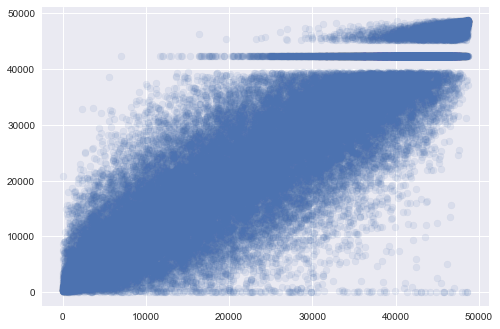

In [70]:
plt.scatter(submission_kernel.TARGET.rank(), pd.Series([col_[0] for col_ in pred_sub]).rank(), alpha=.1)
plt.show()

In [91]:
os.listdir("./result/")

['result.rar',
 'results',
 'results (2)',
 'results (2).zip',
 'results (3)',
 'results (3).zip',
 'results.zip',
 'submission-000-less.csv',
 'submission-000-more.csv',
 'submission-000.csv',
 'submission-001-A.csv',
 'submission-001-B.csv',
 'submission-001-C.csv',
 'submission-003-B.csv',
 'submission-003-C.csv',
 'submission-003-D.csv',
 'submission-005-D.csv',
 'submission-010-sub0.npy',
 'submission-010-sub1.npy',
 'submission-010-sub2.npy',
 'submission-010-sub3.npy',
 'submission-011-A.csv',
 'submission-011-B.csv',
 'submission-012-A.csv',
 'submission-012-B.csv',
 'submission-014-A.csv',
 'submission-014.npy',
 'submission-016-cat1600.csv',
 'submission-016-cat1600.npy',
 'submission-016-ensemble-eta25.csv',
 'submission-016-ensemble.csv',
 'submission-016-lgb.csv',
 'submission-016-lgb.npy',
 'submission-016-lgb2000.csv',
 'submission-016-lgb2000.npy',
 'submission-016-rank-eta25.csv',
 'submission-016-rank-kernel.csv',
 'submission-016-rank-mix3.csv',
 'submission-016-rank

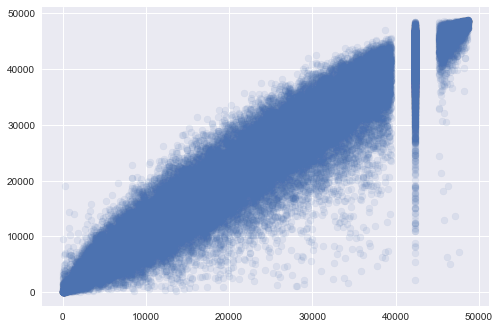

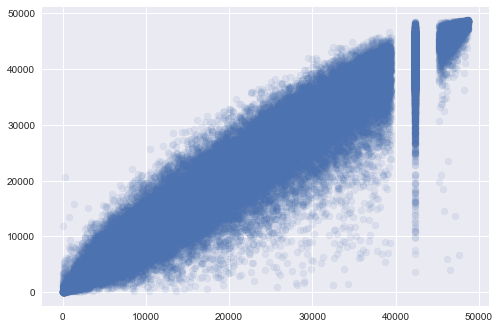

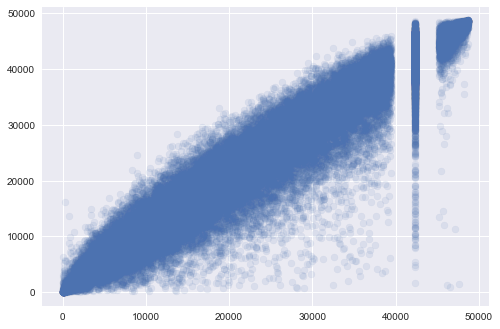

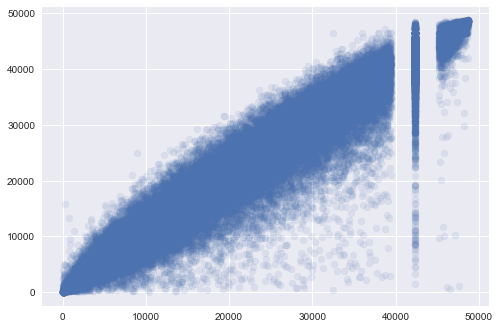

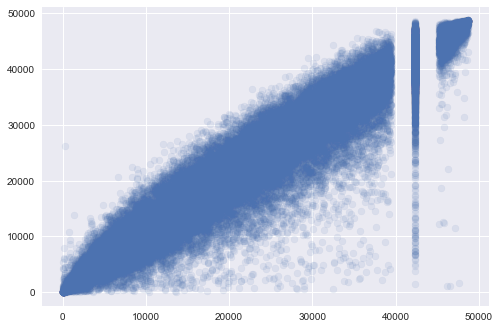

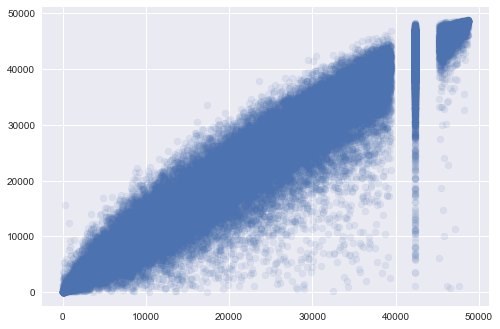

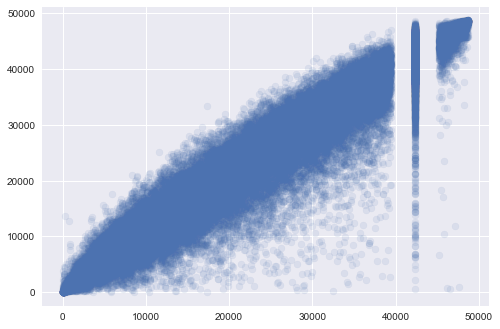

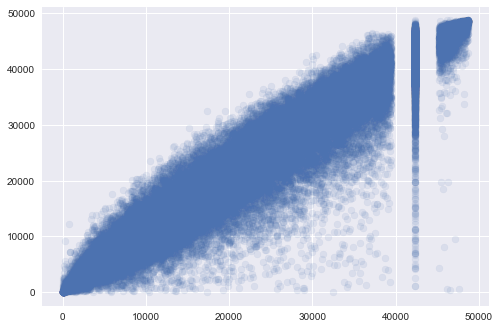

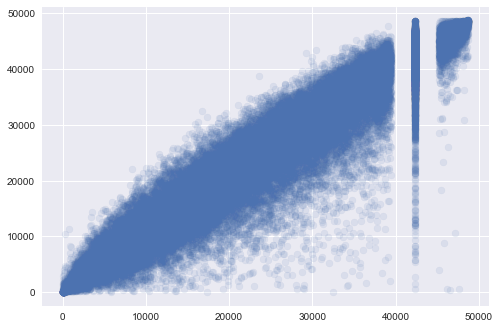

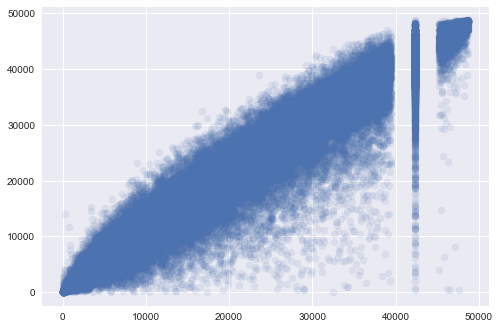

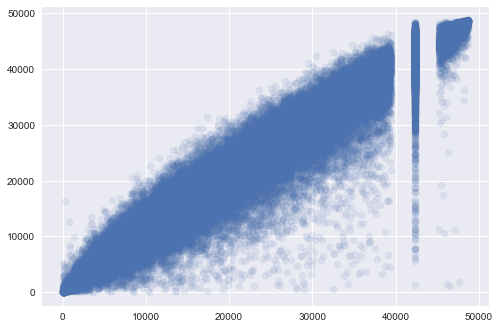

In [95]:

result_fnames =  [
    'submission-022-nn12.npy',
    'submission-022-nn14.npy',
    'submission-022-nn16.npy',
    'submission-022-nn18.npy',
    'submission-022-nn20.npy',
    'submission-022-nn22.npy',
    'submission-022-nn24.npy',
    'submission-022-nn26.npy',
    'submission-022-nn28.npy',
    'submission-022-nn30.npy',
]


avg_sub = np.zeros(submission_kernel.shape[0])
for fname in result_fnames:
    avg_sub += pred_sub
    pred_sub = np.load("./result/{}".format(fname))    
    plt.scatter(submission_kernel.TARGET.rank(), pd.Series(pred_sub).rank(), alpha=.1)
    plt.show()

plt.scatter(submission_kernel.TARGET.rank(), pd.Series(avg_sub).rank(), alpha=.1)
plt.show()

In [100]:
for fname in result_fnames:
    path = "./result/{}".format(fname)
    pred_sub = np.load(path)    
    submission_kernel["TARGET"] = pred_sub
    submission_kernel.to_csv(path[:-3] +"csv", index=False)

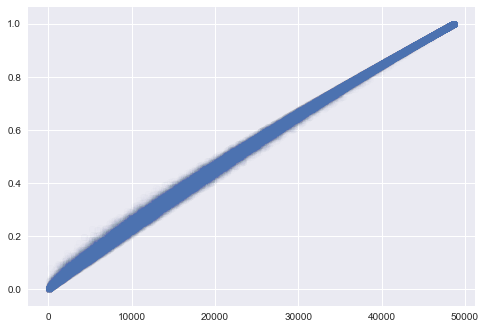

In [109]:
submission_blend02 = pd.read_csv("./result/submission-018-blend02.csv")
pred_sub = np.load("./result/submission-022-nn01.npy")

a = submission_blend02.TARGET.rank()
b = pd.Series(pred_sub).rank()

c = (a + 0.2 * b) / (a.max() + 0.2 * b)

plt.scatter(a, c, alpha=.01)
plt.show()

submission_blend02["TARGET"] = c
submission_blend02.to_csv("./result/submission-022-blend03.csv", index=False)

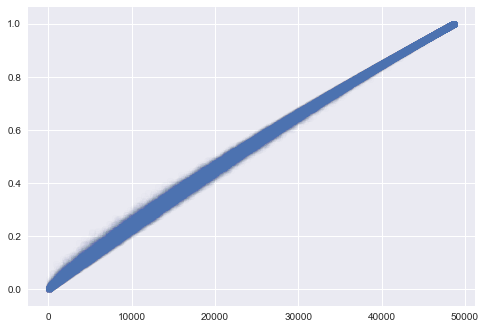

In [121]:
submission_blend02 = pd.read_csv("./result/submission-018-blend02.csv")
submission_nn88_avg = pd.read_csv("./result/submission-022-nn88-avg579.csv")

a = submission_blend02.TARGET.rank()
b = submission_nn88_avg.TARGET.rank()

c = (a + 0.2 * b) / (a.max() + 0.2 * b)

plt.scatter(a, c, alpha=.01)
plt.show()

submission_blend02["TARGET"] = c
submission_blend02.to_csv("./result/submission-022-blend04.csv", index=False)

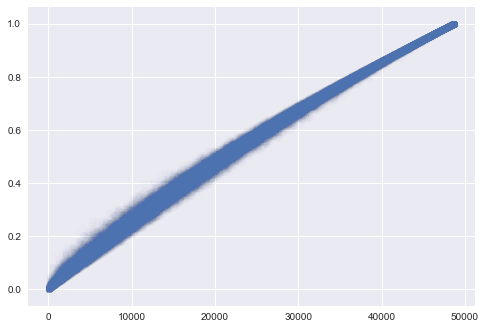

In [4]:
submission_blend02 = pd.read_csv("./result/submission-018-blend02.csv")
submission_nn88_avg = pd.read_csv("./result/submission-022-nn88-avg579.csv")

a = submission_blend02.TARGET.rank()
b = submission_nn88_avg.TARGET.rank()

c = (a + 0.3 * b) / (a.max() + 0.3 * b)

plt.scatter(a, c, alpha=.01)
plt.show()

submission_blend02["TARGET"] = c
submission_blend02.to_csv("./result/submission-022-blend05.csv", index=False)

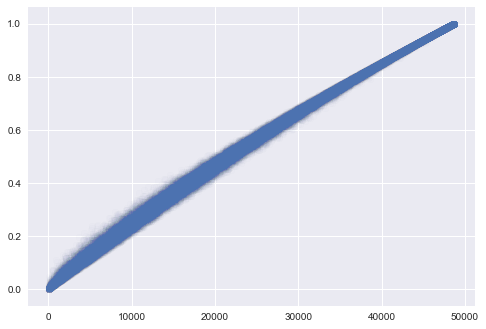

In [5]:
submission_blend02 = pd.read_csv("./result/submission-018-blend02.csv")
submission_nn88_avg = pd.read_csv("./result/submission-022-nn88-avg579.csv")

a = submission_blend02.TARGET.rank()
b = submission_nn88_avg.TARGET.rank()

c = (a + 0.25 * b) / (a.max() + 0.25 * b)

plt.scatter(a, c, alpha=.01)
plt.show()

submission_blend02["TARGET"] = c
submission_blend02.to_csv("./result/submission-022-blend06.csv", index=False)

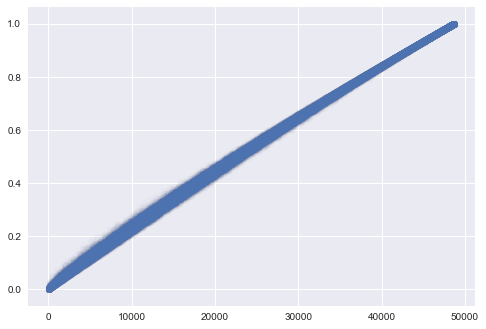

In [6]:
submission_blend02 = pd.read_csv("./result/submission-018-blend02.csv")
submission_nn88_avg = pd.read_csv("./result/submission-022-nn88-avg579.csv")

a = submission_blend02.TARGET.rank()
b = submission_nn88_avg.TARGET.rank()

c = (a + 0.15 * b) / (a.max() + 0.15 * b)

plt.scatter(a, c, alpha=.01)
plt.show()

submission_blend02["TARGET"] = c
submission_blend02.to_csv("./result/submission-022-blend07.csv", index=False)

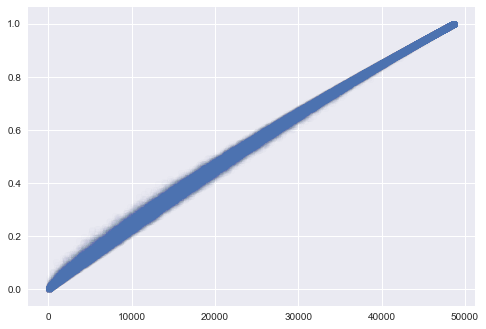

In [11]:
submission_blend02 = pd.read_csv("./result/submission-018-blend02.csv")
submission_nn88_avg = pd.read_csv("./result/submission-022-nn88-avg579.csv")

a = submission_blend02.TARGET.rank()
b = submission_nn88_avg.TARGET.rank()

c = (a + 0.22 * b) / (a.max() + 0.22 * b)

plt.scatter(a, c, alpha=.01)
plt.show()

submission_blend02["TARGET"] = c
submission_blend02.to_csv("./result/submission-022-blend08.csv", index=False)

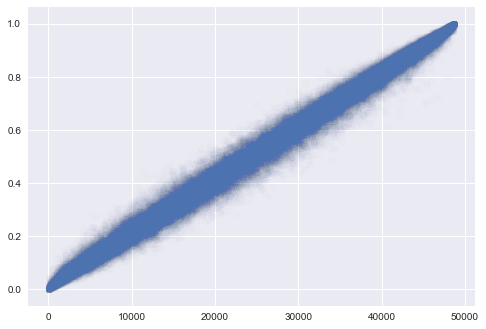

In [13]:
submission_blend02 = pd.read_csv("./result/submission-018-blend02.csv")

def tar_rank(x):
    return x.TARGET.rank().values

sub_022_nn = pd.read_csv("./result/submission-022-nn88-avg579.csv")
sub_020_lgbfs = pd.read_csv("./result/submission-020-lgb2000-fs201-rd0.csv")
sub_018_lgbfs = pd.read_csv("./result/submission-018-lgbfs-rank11.csv")
sub_018_xgb = pd.read_csv("./result/submission-018-xgb-rank6.csv")
                          
a = tar_rank(sub_022_nn)
b = tar_rank(sub_020_lgbfs)
c = tar_rank(sub_018_lgbfs)
d = tar_rank(sub_018_xgb)

e = (a + b + c + d) / (a.max() + b.max() + c.max() + d.max())

plt.scatter(tar_rank(submission_blend02), e, alpha=.01)
plt.show()

submission_blend02["TARGET"] = e
submission_blend02.to_csv("./result/submission-022-blend09.csv", index=False)

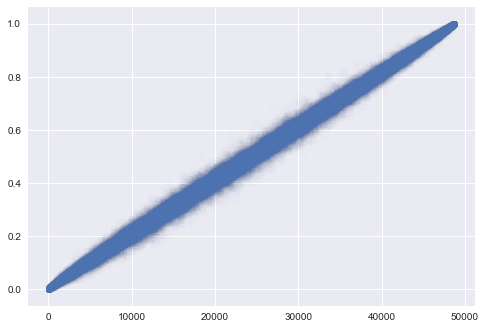

In [20]:
submission_blend02 = pd.read_csv("./result/submission-018-blend02.csv")

def tar_rank(x):
    return x.TARGET.rank().values

sub_022_nn = pd.read_csv("./result/submission-022-nn88-avg579.csv")
sub_020_lgbfs = pd.read_csv("./result/submission-020-lgb2000-fs201-rd0.csv")
sub_018_lgbfs = pd.read_csv("./result/submission-018-lgbfs-rank11.csv")
sub_018_xgb = pd.read_csv("./result/submission-018-xgb-rank6.csv")
                          
a = tar_rank(sub_022_nn)
b = tar_rank(sub_020_lgbfs)
c = tar_rank(sub_018_lgbfs)
d = tar_rank(sub_018_xgb)

e = (.1 * a + .2 * b + c + d) / (.1 * a.max() + .2 * b.max() + c.max() + d.max())

plt.scatter(tar_rank(submission_blend02), e, alpha=.01)
plt.show()

submission_blend02["TARGET"] = e
submission_blend02.to_csv("./result/submission-022-blend10csv", index=False)